# Preprocessing Twin City Tracts

## Brainstation Capstone Project

### Spencer Cox
### Summer, 2022
### Notebook Plan

The objective of this preprocessing notebook is to create a dataset with detailed information on social, economic, and basic demographic information for each census tract in the broader Twin Cities region. We will use this information in conjunction with the parcel data as a tool to understand how corporate residential real estate ownership relates to social and economic demographic information. 

The broader metropolitan area of the Twin Cities contains seven main counties.
   1) Hennepin County, which contains the city of Minneapolis
   2) Ramsey County, which contains the city of St Paul
   3) Washington County
   4) Carver County
   5) Scott County
   6) Dakota County
   7) Anoka County
   
![Metro%20County.png](attachment:Metro%20County.png)

The two main datasets utilized in this analysis include the Met-Council's [Equity Considerations Dataset](https://gisdata.mn.gov/dataset/us-mn-state-metc-society-equity-considerations), a comprehensive dataset integrating data from a range of sources including the ACS, Census, and MetCouncil that measure key economic, racial, and social indicators by census tract in the Twin Cities region. The metadata can be found [here](https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/society_equity_considerations/metadata/metadata.html#Identification_Information). According to the [data description](https://gisdata.mn.gov/dataset/us-mn-state-metc-society-equity-considerations), "These tables were compiled from many different data sources, which are the most recent regionally representative data available. Almost all data in these files describes conditions between 2015 and 2019, and many come from the 2015-2019 five-year American Community Survey estimates. Please contact Matt Schroeder (contact information below) if you need data for earlier ACS releases. Some historical data, describing the first half of the 20th century, is included as well." From this dataset, we will extract the key features for our analysis, and conduct some additional feature engineering. This is detailed below.

The LEHD survey information will be extracted from the Census API, helping us see the occupational breakdown by tract, creating an additional set of features based on occupational data missing from the current analysis.

The tabular data from the ACS and LEHD will be grouped and organized by census tract and joined with the spatial information on the tracts provided by the MetCouncil [here](https://gisdata.mn.gov/dataset/us-mn-state-metc-society-census2010tiger).



In [1]:
# Import key packages for data pre-processing

import fiona
import numpy as np
import pandas as pd
import geopandas as gpd



# Set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Importing the MetroGIS Data
The metadata is available in .xls format at this [link](https://metrocouncil.org/Data-and-Maps/Research-and-Data/Place-based-Equity-Research/Equity-Considerations-Dataset-Fields-(February-202.asx)), detailing each attribute. The 'Overview' dataset used here contains some key analytical features for measuring information about the tract. However, to calculate index features, columns will be required from the each sepcific dataset that contains attribtues specific to that category (Race/ethnicity, housing, economics, etc.)


### Selected Attributes:
In the selection below, I identify attributes to be used in the model with a breif explanation, and in some places will create a plan to engineer new features to condense information.

#### Identification (from overview)
- `TR10`	Identifier for tract (2010 vintage)
- `CTU_PRMRY`Primary city/township (with a plurality of the tract's population)

- `POPTOT_MC`	Total population (Metropolitan Council estimate)

#### Age diversity index (from df1) 
- `P_0017`	Proportion of residents age 0 to 17
- `P_1834`	Proportion of residents age 18 to 39
- `P_3564`	Proportion of residents age 40 to 64
- `P_65UP`	Proportion of residents age 65+
    - Engineer Feature:
        - `AGE_DIV` Age diversity index 

- `AVGHHSIZE`	Average household size

#### Immigrant index (from df1)
- `P_USBORN`	Proportion of residents who were born in the US (includes people born abroad to American citizens)
- `PMIG_GE10`	Proportion of residents who immigrated to US in or after 2010
- `PMIG_GE10`	Proportion of residents who immigrated to US in or after 2010
- `PMIG_0009`	Proportion of residents who immigrated to US 2000-2009
- `PMIG_9099`	Proportion of residents who immigrated to US 1990-1999
- `PMIG_LT90`	Proportion of residents who immigrated to US before 1990
    - Engineer Feature:
        - `IMM_DIV` - Immigration Diversity index 

#### Neighborhood Turnover (from overview)


#### Racial Diversity (from overview)
- `PPLURALRAC`	Indicator of racial concentration (plurality race group's share of total population). *This is a 'whiteness' measurement, or percent of residents who are white.*

- `PWHITENH`	Proportion of residents who identify as White, non-Latino
- `PBLACKNH`	Proportion of residents who identify as Black or African American, non-Latino
- `PASIANNH`	Proportion of residents who identify as Asian, non-Latino
- `PHISPPOP`	Proportion of residents who identify as Hispanic or Latino
- `PAMINDNH`	Proportion of residents who identify as Indigenous, non-Latino
- `POTHMULTNH`	Proportion of residents who identify as Some other race or multiracial, non-Latino
    - Engineer Feature:
        - `RACIAL_DIV` - A racial diversity index to capture the racial diversity of a neighborhood


#### Poverty/Wealth (Overview)
- `PPOV185`	People whose family income is less than 185% of the federal poverty threshold, as a proportion of all people for whom poverty status is determined
- `ACP	1` if Area of Concentrated Poverty (excludes tracts where PSTUDENT>=0.5 OR PPOV_STUDENT>=0.333 from the set of tracts where CONCPOV=1); 0 otherwise
- `PPOV500`	% of people whose income is at least 500% of the federal poverty threshold
- `ACA`	1 if Area of Concentrated Affluence (PPOV500_RAT >= 1.667 OR MD_EMV_RAT >= 1.667); 0 otherwise
- `TR_EDA`	Economically "Distressed" Area according to U.S. Economic Development Administration (1 = yes; 0 = no)


#### Income Diversity (from df3):
 -  `HHTOT_ACS`	Total households, same as occupied housing units (American Community Survey estimate)
 - `PHHI_QNTL1`	Share of households with annual income less than 35,000 (roughly the bottom 20 of households in the region)
 - `PHHI_QNTL2` Share of households with annual income between 35,000 and 59,999 (roughly the next-lowest 20 of households in the region)
 - `PHHI_QNTL3`	Share of households with annual income between 60,000 and 99,999 (roughly the middle 20 of households in the region)
 - `PHHI_QNTL4`	Share of households with annual income between 1000,000 and 149,999 (roughly the next-highest 20 of households in the region)
- `PHHI_QNTL5`	Share of households with annual income 150,000 or more (roughly the top 20 of households in the region)
    - Engineer Feature:
        - `INCOME_DIV` - An income diversity index to capture the income diversity of a neighborhood



#### Change in Wealth (Overview):
- `MDHHINC14`	Median household income, 2010-2014 period (in 2019 dollars)
- `MDHHINCNOW`	Median household income, 2015-2019 period (in 2019 dollars)
    - Engineer Feature:
        - `INC_CHG` - Measures percent change in household income


#### Neighborhood Ownership Composition (Overview):
- `POWNHOME`	Homeownership rate
- `PCOSTBURD`	% housing cost-burdened (housing costs are 30%+ of household income)
- `RP_NETCHG`	Net change in number of housing units, 2010-2019
- `TR_QUALIF`	Low-Income Housing Tax Credit Qualified Census Tract (1 = yes; 0 = no)


#### Changes in Home Price (Overview):
- `GRSRENT14`	Median gross rent (contract rent + utilities), 2010-2014 period (in 2019 dollars)
- `GRSRENTNOW`	Median gross rent (contract rent + utilities), 2015-2019 period (in 2019 dollars)
    - Engineer Feature:
        - `RENT_CHG` - Measures percent change rent
- `MD_EMV_2014`	Median estimated market value of owner-occupied homes in tract in 2014 (in 2019 dollars)
- `MD_EMV_NOW`	Median estimated market value of owner-occupied homes in tract in 2019 (in 2019 dollars)
    - Engineer Feature:
        - `EMV_CHG` - Measures percent change in market value
- `AFF14_LE60`	Proportion of 2014 housing affordable to households at or below 60% of Area Median Income
- `AFFNW_LE60`	Proportion of 2019 housing affordable to households at or below 60% of Area Median Income
    - Engineer Feature:
        - `AFF_CHG` - Measures percent change in deep affordability

- `P_EVICTED`	Eviction rate, 2010-2017 average (weighted by number of renter households)

- `HHOWN_MC`	Total owner-occupied housing units (Metropolitan Council estimate)
- `HHRNT_MC`	Total renter-occupied housing units (Metropolitan Council estimate)
- `HUTOT_MC`	Total housing units (Metropolitan Council estimate)
    - Engineer Feature:
        - `RENTOWN_MIX` - Rent/Own Mix
- `PMV`	Proportion who moved to current housing unit in the last year (out of residents age 1+)
- `MV_MDYR`	Median year households moved into homes
    - Engineer Feature:
        - NGHBR_STAB - 2021 - `MV_MDYR`



#### Public Transit (Overview)
- `PHFTRANSIT`	Proportion of residents living within one-half mile of high-frequency transit
- `COMMLENGTH`	Mean commute length (in minutes)
- `PCOMMTRANS`	Proportion of commuters who took public transportation to work

#### Mixed-Use (Overview)
- `PJOB_LT5`	Proportion of jobs held by workers who live less than 5 miles away (primary jobs only; excludes second or third jobs)

#### Environment (Overview)
- `TR_EJ`	Area of Environmental Justice Concern (1 = yes; 0 = no)
- `ENV_PM25`	Fine particulate matter (2.5 microns or less) (annual average micrograms per cubic meter); air quality standard is 12

#### Geographical information (Overview)
- `geometry` Contains the geographical information for the polygon

## Loading Dataframes

There are five total dataframes, an overview that contains key summary variables across domain topics, and four individual parts. The Tracts Overview dataframe will contain the geographic information for tract parcels, so that will be the main GDF I will merge the others too. I will use each for specific purposes, and then merge them together after processing and identifying key attributes for this analysis.

In [2]:
metro_gdf = gpd.read_file('shp_society_equity_considerations/EquityConsiderationsTractsOverview.shp')
df_1 = gpd.read_file('shp_society_equity_considerations/EquityConsiderationsPart1.dbf')
df_2 = gpd.read_file('shp_society_equity_considerations/EquityConsiderationsPart2.dbf')
df_3 = gpd.read_file('shp_society_equity_considerations/EquityConsiderationsPart3.dbf')
df_4 = gpd.read_file('shp_society_equity_considerations/EquityConsiderationsPart4.dbf')

In [3]:
metro_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 704 entries, 0 to 703
Columns: 117 entries, GEOID10 to geometry
dtypes: float64(103), geometry(1), object(13)
memory usage: 643.6+ KB


In [4]:
# Projection System
metro_gdf.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
metro_gdf.head()

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry
0,27003050107,29450.685312,27003050107,St. Francis,1.00000,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.300,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.000,0.000,0.000,0.062,2007.0,0.101,0.960,0.000,0.000,0.000,0.000,0.040,0.040,"White, non-Latinx",0.960,0.000,0.002,0.000,0.000,0.000,0.000,0.017,0.000,0.0,0.030,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.060,23.0,0.040,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.000,0.013,682.0,0.307,0.171,33.0,3.326,1.60,0.93,1.39,4.0,82.568,0.064,6.81,8.80,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5..."
1,27003050108,27000.684440,27003050108,St. Francis,0.90697,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1978.0,1920.0,1613.0,307.0,5525.0,1808.0,1721.0,1446.0,275.0,5252.0,0.285,0.248,0.385,0.083,0.155,0.690,0.156,3.05,0.945,0.007,0.018,0.120,2011.0,0.110,0.871,0.021,0.005,0.060,0.001,0.042,0.129,"White, non-Latinx",0.871,0.011,0.015,0.001,0.001,0.053,0.000,0.005,0.001,0.0,0.000,0.342,0.154,0.161,0.0,0.0,0.295,0.0,0.0,68006.0,86612.0,0.158,0.339,0.139,0.614,0.126,52670.0,None,None,None,None,None,None,None,0.840,0.204,0.286,0.188,960.0,1041.0,169548.0,212700.0,0.7036,0.4024,0.101,57.0,0.027,0.013,0.0,2662.0,0.070,0.526,32.92,0.972,0.011,0.017,816.0,0.315,0.195,243.0,44.777,1.23,1.81,1.48,4.0,84.987,0.099,7.63,7.14,6.914,27000.684440,2.790857e+07,"POLYGON ((474792.463 5028953.926, 474818.440 5..."
2,27003050109,37346.985868,27003050109,East Bethel,1.00000,1.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,2000.0,1967.0,1866.0,101.0,5720.0,1921.0,1878.0,1741.0,137.0,5481.0,0.222,0.217,0.449,0.112,0.124,0.790,0.086,2.91,0.982,0.000,0.010,0.054,2005.0,0.096,0.930,0.004,0.014,0.020,0.014,0.018,0.070,"White, non-Latinx",0.930,0.000,0.010,0.000,0.000,0.020,0.000,0.004,0.003,0.0,0.000,0.332,0.194,0.118,0.0,0.0,0.401,0.0,0.0,97663.0,94318.0,0.081,0.253,0.186,0.625,0.100,51225.0,None,None,None,None,None,None,None,0.927,0.148,0.226,0.142,0.0,1536.0,195898.0,252250.0,0.4757,0.1971,0.146,39.0,0.064,0.026,0.0,2926.0,0.040,0.547,34.44,0.978,0.010,0.012,454.0,0.219,0.291,111.0,1.547,6.46,7.25,1.82,3.0,84.109,0.119,9.21,6.45,6.941,37346.985868,6.923463e+07,"POLYGON ((488872.762 5027577.808, 488874.904 5..."
3,27003050110,23900.130557,27003050110,East Bethel,1.00000,1.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,996.0,976.0,892.0,84.0,2713.0,1022.0,991.0,932.0,59.0,2670.0,0.162,0.233,0.494,0.110,0.141,0.765,0.094,2.69,0.985,0.000,0.011,0.090,2003.0,0.115,0.955,0.000,0.015,0.007,0.007,0.016,0.045,"White, non-Latinx",0.955,0.000,0.009,0.000,0.000,0.002,0.001,0.000,0.010,0.0,0.002,0.343,0.180,0.124,0.0,0.0,0.452,0.0,0.0,953

## Creating New Columns

We'll create the new columns here based on the attributes selected above.

In instances where I'm creating a diversity index, I will use Gini-Simpson index, the standard typically used in social science analysis to examine diversity. The Gini-Simpson measures the likelihood that two people selected at random from a
given area represent different types. In this case, it is a measure of whether the race of the
chosen people is the same. See the wiki entry [here](https://en.wikipedia.org/wiki/Diversity_index#Gini%E2%80%93Simpson_index).

The Gini-Simpson Diversity index (D) is calculated by:

$$ 
D = 1- \Bigg(\frac{\sum n_i (n_i-1)}{N(N-1)}\Bigg)
$$

Where n_i is the number of individuals in the i-th species and N is the total number of individuals in the community.


### Age diversity index from-
Relevant columns:
- `P_0017` Proportion of residents age 0 to 17
- `P_1834` Proportion of residents age 18 to 39
- `P_3564` Proportion of residents age 40 to 64
- `P_65UP` Proportion of residents age 65+
- `POPTOT_ACS`	Total population (American Community Survey estimate)

Engineer Feature:
`AGE_DIV` Age diversity index 

Since all are given in proportions, we will reverse engineer total population using the original ACS population estimate.

In [6]:
# Calculate Numerator using the Proportion to find the number
num_P_0017 = (metro_gdf['P_0017']*metro_gdf['POPTOT_ACS'])*((metro_gdf['P_0017']*metro_gdf['POPTOT_ACS'])-1)
num_P_1834 = (metro_gdf['P_1834']*metro_gdf['POPTOT_ACS'])*((metro_gdf['P_0017']*metro_gdf['POPTOT_ACS'])-1)
num_P_3564 = (metro_gdf['P_3564']*metro_gdf['POPTOT_ACS'])*((metro_gdf['P_0017']*metro_gdf['POPTOT_ACS'])-1)
num_P_65UP = (metro_gdf['P_65UP']*metro_gdf['POPTOT_ACS'])*((metro_gdf['P_0017']*metro_gdf['POPTOT_ACS'])-1)

# Calculate Index
metro_gdf['AGE_DIV'] = 1- ((num_P_0017+num_P_1834+num_P_3564+num_P_65UP)/(metro_gdf['POPTOT_ACS']*(metro_gdf['POPTOT_ACS']-1)))



In [7]:
metro_gdf['AGE_DIV'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 704 entries, 0 to 703
Series name: AGE_DIV
Non-Null Count  Dtype  
--------------  -----  
703 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


### Immigrant index (from df1)

- `P_USBORN` Proportion of residents who were born in the US (includes people born abroad to American citizens)
- `PMIG_GE10`	Proportion of residents who immigrated to US in or after 2010
- `PMIG_0009`	Proportion of residents who immigrated to US 2000-2009
- `PMIG_9099`	Proportion of residents who immigrated to US 1990-1999
- `PMIG_LT90`	Proportion of residents who immigrated to US before 1990
- `POPTOT_ACS`	Total population (American Community Survey estimate)

- Engineer Feature:
    - `IMM_DIV` - Immigration Diversity index (high values = higher diversity, lower values = lower diversity)

In [8]:
# Calculate Numerator using the Proportion to find the number
num_P_USBORN = (df_1['P_USBORN']*df_1['POPTOT_ACS'])*((df_1['P_USBORN']*df_1['POPTOT_ACS'])-1)
num_PMIG_GE10 = (df_1['PMIG_GE10']*df_1['POPTOT_ACS'])*((df_1['PMIG_GE10']*df_1['POPTOT_ACS'])-1)
num_PMIG_0009 = (df_1['PMIG_0009']*df_1['POPTOT_ACS'])*((df_1['PMIG_0009']*df_1['POPTOT_ACS'])-1)
num_PMIG_9099 = (df_1['PMIG_9099']*df_1['POPTOT_ACS'])*((df_1['PMIG_9099']*df_1['POPTOT_ACS'])-1)
num_PMIG_LT90 = (df_1['PMIG_LT90']*df_1['POPTOT_ACS'])*((df_1['PMIG_LT90']*df_1['POPTOT_ACS'])-1)

# Calculate Index and Assign it to a new column in metro_gdf
metro_gdf['IMM_DIV'] = 1 - ((num_P_USBORN + num_PMIG_GE10 + num_PMIG_0009 + num_PMIG_9099 + num_PMIG_LT90)/ \
(df_1['POPTOT_ACS']*(df_1['POPTOT_ACS']-1)))

## Racial Diversity (metro_gdf)

`PWHITENH` Proportion of residents who identify as White, non-Latino

`PBLACKNH` Proportion of residents who identify as Black or African American, non-Latino

`PASIANNH` Proportion of residents who identify as Asian, non-Latino

`PHISPPOP` Proportion of residents who identify as Hispanic or Latino

`PAMINDNH` Proportion of residents who identify as Indigenous, non-Latino

`POTHMULTNH` Proportion of residents who identify as Some other race or multiracial, non-Latino

- Engineer Feature:
    `RACIAL_DIV` - A racial diversity index to capture the racial diversity of a neighrbhood

In [9]:
# Calculate Numerator using the Proportion to find the number
num_PWHITENH = (metro_gdf['PWHITENH']*metro_gdf['POPTOT_ACS'])*((metro_gdf['PWHITENH']*metro_gdf['POPTOT_ACS'])-1)
num_PBLACKNH = (metro_gdf['PBLACKNH']*metro_gdf['POPTOT_ACS'])*((metro_gdf['PBLACKNH']*metro_gdf['POPTOT_ACS'])-1)
num_PASIANNH = (metro_gdf['PASIANNH']*metro_gdf['POPTOT_ACS'])*((metro_gdf['PASIANNH']*metro_gdf['POPTOT_ACS'])-1)
num_PHISPPOP = (metro_gdf['PHISPPOP']*metro_gdf['POPTOT_ACS'])*((metro_gdf['PHISPPOP']*metro_gdf['POPTOT_ACS'])-1)
num_PAMINDNH = (metro_gdf['PAMINDNH']*metro_gdf['POPTOT_ACS'])*((metro_gdf['PAMINDNH']*metro_gdf['POPTOT_ACS'])-1)
num_POTHMULTNH = (metro_gdf['POTHMULTNH']*metro_gdf['POPTOT_ACS'])*((metro_gdf['POTHMULTNH']*metro_gdf['POPTOT_ACS'])-1)

# Calculate Index and Assign it to a new column in metro_gdf
metro_gdf['RACIAL_DIV'] = 1 - ((num_PWHITENH + num_PBLACKNH + num_PASIANNH + num_PHISPPOP + num_PAMINDNH + num_POTHMULTNH)/ \
(metro_gdf['POPTOT_ACS']*(metro_gdf['POPTOT_ACS']-1)))

#### Income Diversity (from df3):
 - `HHTOT_ACS`	Total households, same as occupied housing units (American Community Survey estimate)
 - `PHHI_QNTL1`	Share of households with annual income less than 35,000 (roughly the bottom 20 of households in the region)
 - `PHHI_QNTL2` Share of households with annual income between 35,000 and 59,999 (roughly the next-lowest 20 of households in the region
 - `PHHI_QNTL3`	Share of households with annual income between 60,000 and 99,999 (roughly the middle 20 of households in the region)
 - `PHHI_QNTL4`	Share of households with annual income between 1000,000 and 149,999 (roughly the next-highest 20 of households in the region)
- `PHHI_QNTL5`	Share of households with annual income 150,000 or more (roughly the top 20% of households in the region)
    - Engineer Feature:
        - `INCOME_DIV` - An income diversity index to capture the income diversity of a neighborhood

In [10]:
# Calculate Numerator using the Proportion to find the number
num_PHHI_QNTL1 = (df_3['PHHI_QNTL1']*df_3['HHTOT_ACS'])*((df_3['PHHI_QNTL1']*df_3['HHTOT_ACS'])-1)
num_PHHI_QNTL2 = (df_3['PHHI_QNTL2']*df_3['HHTOT_ACS'])*((df_3['PHHI_QNTL2']*df_3['HHTOT_ACS'])-1)
num_PHHI_QNTL3 = (df_3['PHHI_QNTL3']*df_3['HHTOT_ACS'])*((df_3['PHHI_QNTL3']*df_3['HHTOT_ACS'])-1)
num_PHHI_QNTL4 = (df_3['PHHI_QNTL4']*df_3['HHTOT_ACS'])*((df_3['PHHI_QNTL4']*df_3['HHTOT_ACS'])-1)
num_PHHI_QNTL5 = (df_3['PHHI_QNTL5']*df_3['HHTOT_ACS'])*((df_3['PHHI_QNTL5']*df_3['HHTOT_ACS'])-1)

# Calculate Index and Assign it to a new column in metro_gdf
metro_gdf['INCOME_DIV'] = 1 - ((num_PHHI_QNTL1 + num_PHHI_QNTL2 + num_PHHI_QNTL3 + num_PHHI_QNTL4 + num_PHHI_QNTL5)/ \
(df_3['HHTOT_ACS']*(df_3['HHTOT_ACS']-1)))

#### Change in Wealth (metro_gdf):
- `MDHHINC14`	Median household income, 2010-2014 period (in 2019 dollars)
- `MDHHINCNOW`	Median household income, 2015-2019 period (in 2019 dollars)
    - Engineer Feature:
        - `INC_CHG` - Measures percent change in household income

In [11]:
# Calculate a simple percent change between HH income in 2010-2014 and 2015-2019
metro_gdf['INC_CHG'] = ((metro_gdf['MDHHINCNOW'] - metro_gdf['MDHHINC14'])/metro_gdf['MDHHINC14'])*100

#### Changes in Home Price (Overview):
- `GRSRENT14`	Median gross rent (contract rent + utilities), 2010-2014 period (in 2019 dollars)
- `GRSRENTNOW`	Median gross rent (contract rent + utilities), 2015-2019 period (in 2019 dollars)
    - Engineer Feature:
        - `RENT_CHG` - Measures percent change rent
- `MD_EMV_201`	Median estimated market value of owner-occupied homes in tract in 2014 (in 2019 dollars)
- `MD_EMV_NOW`	Median estimated market value of owner-occupied homes in tract in 2019 (in 2019 dollars)
    - Engineer Feature:
        - `EMV_CHG` - Measures percent change in market value
- `AFF14_LE60`	Proportion of 2014 housing affordable to households at or below 60% of Area Median Income
- `AFFNW_LE60`	Proportion of 2019 housing affordable to households at or below 60% of Area Median Income
    - Engineer Feature:
        - `AFF_CHG` - Measures percent change in deep affordability

- `P_EVICTED`	Eviction rate, 2010-2017 average (weighted by number of renter households)

- `HHOWN_MC`	Total owner-occupied housing units (Metropolitan Council estimate)
- `HHRNT_MC`	Total renter-occupied housing units (Metropolitan Council estimate)
- `HUTOT_MC`	Total housing units (Metropolitan Council estimate)
    - Engineer Feature:
        - `OWNER_RATIO` - Owners over total housing units
- `MV_MDYR`	Median year households moved into homes
    - Engineer Feature:
        - `NBR_STAB` - (2021 - `MV_MDYR`)/(2021 - mean(`MV_MDYR`)

In [12]:
# Percent Rent Change
metro_gdf['RENT_CHG'] = ((metro_gdf['GRSRENTNOW'] - metro_gdf['GRSRENT14'])/metro_gdf['GRSRENT14'])*100

#Percent change in median market value of home
metro_gdf['EMV_CHG'] = ((metro_gdf['MD_EMV_NOW'] - metro_gdf['MD_EMV_201'])/metro_gdf['MD_EMV_201'])*100

#Percent change in deep affordability
metro_gdf['AFF_CHG'] = ((metro_gdf['AFFNW_LE60'] - metro_gdf['AFF14_LE60'])/metro_gdf['AFF14_LE60'])*100

#Owner Ratio
metro_gdf['OWNER_RATIO'] = metro_gdf['HHOWN_MC']/metro_gdf['HUTOT_MC']


In [13]:
# Neighborhood Stability
# For counties with 0 for MV_MDYR, will impute the median
median_movein = metro_gdf['MV_MDYR'].median()
metro_gdf.loc[metro_gdf['MV_MDYR'] == 0, 'MV_MDYR'] = median_movein

#Extract parcels where Median year is greater than 1900 (removing parcels without data)
med_yearsmovedin = 2021 - metro_gdf['MV_MDYR']
med_yearsmovedin_mean = med_yearsmovedin.mean()

metro_gdf['NBR_STAB'] = med_yearsmovedin/med_yearsmovedin_mean

## Check for Data Completeness
Some of the fields in our calculated columns have null values. First we need to figure out why, and then attempt to solve the problem.

In [14]:
metro_gdf.isna().sum()

GEOID10          0
Shape_Leng       0
TR10             0
CTU_PRMRY        0
PCTU_PRMRY       0
PCTU_WHOLE       0
WS_PRMRY         0
SD_PRMRY         0
TR_OPPZONE       0
TR_QUALIF        0
TR_EJ            0
TR_EDA           0
HUTOT_MC         0
HHTOT_MC         0
HHOWN_MC         0
HHRNT_MC         0
POPTOT_MC        0
HUTOT_ACS        0
HHTOT_ACS        0
HHOWN_ACS        0
HHRNT_ACS        0
POPTOT_ACS       0
P_0017           0
P_1834           0
P_3564           0
P_65UP           0
PHHSIZE1         0
PHHSIZE2_4       0
PHHSIZE5UP       0
AVGHHSIZE        0
P_USBORN         0
PMIG_GE10        0
P_ENGLIMIT       0
PMV              0
MV_MDYR          0
PD_ANY           0
PWHITENH         0
PBLACKNH         0
PASIANNH         0
PHISPPOP         0
PAMINDNH         0
POTHMULTNH       0
PBIPOC           0
PLURALRACE       1
PPLURALRAC       0
PBANC_AFRI       0
PBANC_AFAM       0
PARAC_AIND       0
PARAC_HMON       0
PLAT_MEXI        0
PLAT_PUER        0
PIND_DAKO        0
PIND_OJIB   

In [15]:
#Identify null value
metro_gdf.loc[metro_gdf['AGE_DIV'].isna()]

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB
632,27123980000,17532.83678,27123980000,St. Paul,1.0,1.0,Ramsey-Washington Metro WD,St. Paul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.12,0.88,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1050.0,0.142,0.32,0.0,0.0,0.0,0.0,0.0,0.0,87.908,0.256,0.0,0.0,0.0,17532.83678,1.269647e+07,"POLYGON ((499212.700 4971939.569, 499223.500 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984845


According to the metadata, tract 27123980000 lacks population and housing units. We will remove it from this analysis, therefore getting rid of the null values in the age, immigration, and racial diversity indexes. 

In [16]:
# Dropped
metro_gdf.drop([632], inplace= True)

In [17]:
# Check nulls for remaining columns
metro_gdf.loc[metro_gdf['INCOME_DIV'].isna()]

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB
592,27123040802,4361.837159,27123040802,Arden Hills,1.0,1.0,Rice Creek WD,Mounds View,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1569.0,0.0,0.0,0.0,0.0,1785.0,0.006,0.994,0.000,0.000,0.0,0.0,0.0,0.0,0.955,0.024,0.022,0.462,2009.0,0.032,0.810,0.035,0.066,0.046,0.000,0.042,0.190,"White, non-Latinx",0.810,0.022,0.028,0.015,0.011,0.026,0.004,0.000,0.000,0.002,0.0,0.324,0.154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006,0.067,0.0,None,None,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.087,0.230,17.61,0.725,0.039,0.236,1065.0,0.282,0.146,0.0,0.0,0.94,0.59,1.59,17.0,88.667,0.085,0.0,0.0,7.880,4361.837159,1.067707e+06,"POLYGON ((486638.401 4989714.443, 486666.917 4...",0.994557,0.087239,0.334626,NaN,NaN,NaN,NaN,NaN,NaN,0.984845
676,27163070801,1921.374145,27163070801,Bayport,1.0,0.0,Middle St. Croix WMO,Stillwater,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,0.0,0.0,0.0,0.0,951.0,0.000,0.515,0.427,0.058,0.0,0.0,0.0,0.0,0.896,0.005,0.041,0.333,2009.0,0.000,0.345,0.436,0.012,0.041,0.121,0.045,0.655,"Black or African American, non-Latinx",0.436,0.043,0.361,0.000,0.000,0.025,0.000,0.014,0.128,0.000,0.0,0.127,0.045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188,0.131,8819.0,None,None,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.012,0.834,0.00,0.000,0.000,0.000,908.0,0.122,0.343,0.0,0.0,0.57,1.10,0.82,10.0,97.812,0.036,0.0,0.0,7.187,1921.374145,2.160169e+05,"POLYGON ((516589.263 4986313.374, 516663.862 4...",1.001053,0.193736,0.673096,NaN,NaN,NaN,NaN,NaN,NaN,0.984845
677,27163070802,3661.303183,27163070802,Oak Park Heights,1.0,0.0,Middle St. Croix WMO,Stillwater,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,369.0,0.0,0.0,0.0,0.0,413.0,0.000,0.523,0.438,0.039,0.0,0.0,0.0,0.0,0.920,0.000,0.019,0.300,2009.0,0.000,0.341,0.358,0.019,0.041,0.199,0.041,0.659,"Black or African American, non-Latinx",0.358,0.000,0.337,0.000,0.019,0.000,0.022,0.019,0.140,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164,0.212,13750.0,None,None,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.016,0.695,0.00,0.000,0.000,0.000,341.0,0.130,0.366,0.0,0.0,1.04,0.72,1.23,11.0,89.173,0.074,0.0,0.0,7.214,3661.303183,7.491185e+05,"POLYGON ((515616.294 4985357.667, 515414.528 4...",1.002427,0.151562,0.713957,NaN,NaN,NaN,NaN,NaN,NaN,0.984845


The three rrows here contain null values for all of the remaining engineered attributes, save rent change. All of them are lacking data for these columns. 

To impute these values, we will use the mean value of households in the same geographical area (CTU_PRMRY) or the same values in the case of only one other value in the same municipality as a close enough approximation.

In [18]:
Arden_Hills = metro_gdf.loc[(metro_gdf['CTU_PRMRY'] == 'Arden Hills') & (metro_gdf['TR10'] != '27123040802')]
Bayport = metro_gdf.loc[(metro_gdf['CTU_PRMRY']== 'Bayport') & (metro_gdf['TR10'] != '27163070801')]
OakParkHeights = metro_gdf.loc[(metro_gdf['CTU_PRMRY']== 'Oak Park Heights') & (metro_gdf['TR10'] != '27163070802')]

In [19]:
Bayport.head()

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB
675,27163070704,14297.183696,27163070704,Bayport,0.99362,0.0,Middle St. Croix WMO,Stillwater,0.0,0.0,0.0,0.0,1072.0,1004.0,752.0,252.0,2352.0,1185.0,1139.0,816.0,323.0,2772.0,0.238,0.185,0.392,0.184,0.299,0.622,0.078,2.42,0.96,0.015,0.005,0.197,2011.0,0.12,0.927,0.018,0.004,0.028,0.004,0.019,0.073,"White, non-Latinx",0.927,0.005,0.004,0.0,0.0,0.017,0.0,0.0,0.004,0.0,0.0,0.358,0.158,0.13,0.0,0.0,0.382,0.0,0.0,61240.0,78221.0,0.191,0.247,0.208,0.557,0.114,56146.0,None,None,None,None,None,None,None,0.716,0.267,0.594,0.143,1090.0,1343.0,195466.0,262850.0,0.5453,0.307,0.142,16.0,0.009,0.115,0.0,1153.0,0.271,0.356,23.11,0.941,0.011,0.048,3208.0,0.204,0.287,187.0,26.807,0.42,1.8,0.28,4.0,88.533,0.042,9.13,2.97,7.142,14297.183696,8.226126e+06,"POLYGON ((516912.454 4986172.695, 517048.430 4...",0.762513,0.077957,0.13922,0.79691,27.728609,23.211009,34.473515,-43.700715,0.701493,0.820704


In [20]:
means = Arden_Hills[['INCOME_DIV', 'INC_CHG', 'RENT_CHG', 'EMV_CHG', 'AFF_CHG', 'OWNER_RATIO']].mean()
means

INCOME_DIV      0.781587
INC_CHG         1.180809
RENT_CHG       -0.555337
EMV_CHG        14.992223
AFF_CHG       -12.561310
OWNER_RATIO     0.822719
dtype: float64

In [21]:
# Arden Hills
metro_gdf.loc[metro_gdf['TR10'] == '27123040802', 'INCOME_DIV'] = 0.781587
metro_gdf.loc[metro_gdf['TR10'] == '27123040802', 'INC_CHG'] = 1.180809
metro_gdf.loc[metro_gdf['TR10'] == '27123040802', 'RENT_CHG'] = -0.555337
metro_gdf.loc[metro_gdf['TR10'] == '27123040802', 'EMV_CHG'] = 14.992223
metro_gdf.loc[metro_gdf['TR10'] == '27123040802', 'AFF_CHG'] = -12.561310
metro_gdf.loc[metro_gdf['TR10'] == '27123040802', 'OWNER_RATIO'] = 0.822719

#Bayport
metro_gdf.loc[metro_gdf['TR10'] == '27163070801', 'INCOME_DIV'] = 0.79691
metro_gdf.loc[metro_gdf['TR10'] == '27163070801', 'INC_CHG'] = 27.728609
metro_gdf.loc[metro_gdf['TR10'] == '27163070801', 'RENT_CHG'] = 23.211009
metro_gdf.loc[metro_gdf['TR10'] == '27163070801', 'EMV_CHG'] = 34.473515
metro_gdf.loc[metro_gdf['TR10'] == '27163070801', 'AFF_CHG'] = -43.700715
metro_gdf.loc[metro_gdf['TR10'] == '27163070801', 'OWNER_RATIO'] = 0.701493

#OakPark
metro_gdf.loc[metro_gdf['TR10'] == '27163070802', 'INCOME_DIV'] = 0.782794
metro_gdf.loc[metro_gdf['TR10'] == '27163070802', 'INC_CHG'] = 16.006076
metro_gdf.loc[metro_gdf['TR10'] == '27163070802', 'RENT_CHG'] = 8.018868
metro_gdf.loc[metro_gdf['TR10'] == '27163070802', 'EMV_CHG'] = 11.245881
metro_gdf.loc[metro_gdf['TR10'] == '27163070802', 'AFF_CHG'] = -10.835351
metro_gdf.loc[metro_gdf['TR10'] == '27163070802', 'OWNER_RATIO'] = 0.631193

*Note: This solution, both the imputing process and the code, could use some discussion - not very satisfied! But continued to run into errors, and this worked.*

In [22]:
#Check for remaining null vaules
metro_gdf.isna().sum()

GEOID10          0
Shape_Leng       0
TR10             0
CTU_PRMRY        0
PCTU_PRMRY       0
PCTU_WHOLE       0
WS_PRMRY         0
SD_PRMRY         0
TR_OPPZONE       0
TR_QUALIF        0
TR_EJ            0
TR_EDA           0
HUTOT_MC         0
HHTOT_MC         0
HHOWN_MC         0
HHRNT_MC         0
POPTOT_MC        0
HUTOT_ACS        0
HHTOT_ACS        0
HHOWN_ACS        0
HHRNT_ACS        0
POPTOT_ACS       0
P_0017           0
P_1834           0
P_3564           0
P_65UP           0
PHHSIZE1         0
PHHSIZE2_4       0
PHHSIZE5UP       0
AVGHHSIZE        0
P_USBORN         0
PMIG_GE10        0
P_ENGLIMIT       0
PMV              0
MV_MDYR          0
PD_ANY           0
PWHITENH         0
PBLACKNH         0
PASIANNH         0
PHISPPOP         0
PAMINDNH         0
POTHMULTNH       0
PBIPOC           0
PLURALRACE       0
PPLURALRAC       0
PBANC_AFRI       0
PBANC_AFAM       0
PARAC_AIND       0
PARAC_HMON       0
PLAT_MEXI        0
PLAT_PUER        0
PIND_DAKO        0
PIND_OJIB   

In [23]:
metro_gdf.loc[metro_gdf['RENT_CHG'].isna()]

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB
29,27003050235,18850.843109,27003050235,Ham Lake,1.0,1.0,Coon Creek WD,Anoka-Hennepin,0.0,0.0,0.0,0.0,1175.0,1129.0,1062.0,67.0,3039.0,1161.0,1100.0,1065.0,35.0,2771.0,0.214,0.154,0.436,0.196,0.216,0.728,0.055,2.51,0.959,0.000,0.046,0.033,2001.0,0.112,0.913,0.000,0.048,0.000,0.018,0.021,0.087,"White, non-Latinx",0.913,0.000,0.019,0.000,0.035,0.000,0.0,0.008,0.010,0.0,0.000,0.329,0.197,0.188,0.0,0.0,0.339,0.0,0.0,74661.0,74750.0,0.199,0.207,0.125,0.564,0.230,54879.0,None,None,None,None,None,None,None,0.968,0.146,0.478,0.138,0.0,0.0,212691.0,269850.0,0.5148,0.2961,0.587,16.0,0.043,0.010,0.0,1509.0,0.087,0.387,29.61,0.992,0.000,0.008,1151.0,0.167,0.354,59.0,3.610,0.80,3.88,3.80,3.0,85.491,0.126,9.00,5.44,7.238,18850.843109,1.679522e+07,"POLYGON ((482806.514 5016055.791, 483830.438 5...",0.786284,0.079695,0.163421,0.787926,0.119205,NaN,26.874198,-42.482517,0.903830,1.641408
89,27019090501,12229.991485,27019090501,Chanhassen,1.0,0.0,Minnehaha Creek WD,Minnetonka,0.0,0.0,0.0,0.0,952.0,920.0,879.0,41.0,2851.0,900.0,872.0,843.0,29.0,2570.0,0.294,0.111,0.494,0.102,0.153,0.694,0.154,2.95,0.938,0.005,0.027,0.096,2005.0,0.038,0.899,0.009,0.033,0.039,0.000,0.021,0.101,"White, non-Latinx",0.899,0.000,0.009,0.011,0.000,0.018,0.0,0.000,0.003,0.0,0.000,0.345,0.179,0.034,0.0,0.0,0.724,1.0,8.0,133351.0,160833.0,0.053,0.150,0.529,0.476,0.220,111250.0,None,None,None,None,None,None,None,0.967,0.164,0.280,0.161,0.0,0.0,406483.0,460200.0,0.0167,0.0182,0.304,3.0,0.010,0.000,0.0,1338.0,0.152,0.179,27.12,0.975,0.014,0.011,143.0,0.293,0.338,135.0,7.155,2.64,2.15,2.82,6.0,85.843,0.061,7.62,6.97,7.188,12229.991485,8.874878e+06,"POLYGON ((452062.868 4971061.448, 452091.848 4...",0.705981,0.119032,0.188741,0.658541,20.608769,NaN,13.215067,8.982036,0.923319,1.313127
93,27019090602,8621.636899,27019090602,Chanhassen,1.0,0.0,Riley-Purgatory-Bluff Creek WD,Minnetonka,0.0,0.0,0.0,0.0,1027.0,1018.0,981.0,37.0,3045.0,1036.0,1036.0,1022.0,14.0,3039.0,0.251,0.197,0.470,0.083,0.069,0.843,0.088,2.93,0.934,0.029,0.012,0.115,2005.0,0.021,0.896,0.028,0.030,0.030,0.000,0.016,0.104,"White, non-Latinx",0.896,0.000,0.029,0.009,0.000,0.026,0.0,0.026,0.000,0.0,0.003,0.384,0.131,0.091,0.0,0.0,0.687,1.0,8.0,128337.0,151250.0,0.050,0.153,0.504,0.595,0.133,86905.0,None,None,None,None,None,None,None,0.986,0.141,0.000,0.143,0.0,0.0,334884.0,394200.0,0.0484,0.0241,0.328,2.0,0.008,0.000,0.0,1526.0,0.245,0.123,26.91,0.939,0.045,0.016,57.0,0.308,0.135,21.0,0.000,1.46,1.46,1.46,14.0,87.419,0.044,7.53,15.29,7.339,8621.636899,3.591908e+06,"POLYGON ((456580.946 4970992.483, 456632.480 4...",0.748996,0.126340,0.194408,0.670063,17.853776,NaN,17.712402,-50.206612,0.955209,1.313127
390,27053026823,8654.284785,27053026823,Brooklyn Park,1.0,1.0,West Mississippi WMO,Osseo,0.0,0.0,1.0,0.0,1

It looks like there are very few renters in this area with no rent data collected, therefore allowing us to put the Rent_Change comfortably at 0.

There are still some very strange numbers in the `RENT_CHG` category, including both -100s and 'inf'

In [24]:
# infinity means num/0 or missing grsrent14=0, -100 means grsrentnow = 0 while grsrent14 is not 0
metro_gdf['RENT_CHG'].value_counts()

-100.000000    18
 inf           10
 10.294118      2
 0.891862       2
 8.333333       2
 12.500000      2
 7.488987       2
 0.000000       2
-2.234043       2
-3.285871       2
 0.090498       1
-2.212389       1
-27.319588      1
 24.077869      1
 12.218650      1
 3.908555       1
 19.327731      1
 4.250200       1
 1.609658       1
 12.357581      1
 20.719738      1
-0.993677       1
 15.442092      1
-10.178710      1
-36.027875      1
 0.312500       1
 7.086614       1
 30.971660      1
 4.651163       1
 44.912281      1
-1.502732       1
-4.410355       1
 10.650888      1
 13.755158      1
 74.129353      1
-2.513661       1
 84.722222      1
-7.644500       1
 26.503568      1
 12.984055      1
 2.799552       1
 7.476636       1
 10.023041      1
 11.163671      1
-14.273720      1
 2.145329       1
 29.052823      1
 13.039797      1
 12.635079      1
 6.301653       1
 15.659955      1
 4.192547       1
 2.169625       1
 16.484848      1
 4.377104       1
 21.511628

In [25]:
# A blunt work around will be to use the median to impute missing values, leading to less overall distortion across other tracts

#find median
median_2014 = metro_gdf['GRSRENT14'].median()
median_NOW = metro_gdf['GRSRENTNOW'].median()

#impute with median
metro_gdf.loc[metro_gdf['GRSRENT14'] == 0, 'GRSRENT14'] = median_2014
metro_gdf.loc[metro_gdf['GRSRENTNOW'] == 0, 'GRSRENTNOW'] = median_NOW

#re-run
metro_gdf['RENT_CHG'] = ((metro_gdf['GRSRENTNOW'] - metro_gdf['GRSRENT14'])/metro_gdf['GRSRENT14'])*100

#check
metro_gdf['RENT_CHG'].value_counts()


 9.302326      8
 8.333333      2
 0.891862      2
-30.370370     2
 12.500000     2
-2.234043      2
-3.285871      2
 7.488987      2
 10.294118     2
 0.000000      2
-36.027875     1
 15.442092     1
 4.250200      1
 0.312500      1
-27.319588     1
 24.077869     1
 1.609658      1
 12.218650     1
-10.178710     1
 19.327731     1
 12.357581     1
 20.719738     1
 4.651163      1
-0.993677      1
 0.090498      1
 30.971660     1
 25.000000     1
 7.086614      1
-2.513661      1
-8.055010      1
 19.630282     1
 44.912281     1
-1.502732      1
-4.410355      1
 10.650888     1
 13.755158     1
 74.129353     1
 84.722222     1
 3.908555      1
-7.644500      1
 26.503568     1
 12.984055     1
 2.799552      1
 7.476636      1
 10.023041     1
 11.163671     1
-14.273720     1
-2.212389      1
 29.617486     1
 29.052823     1
 2.145329      1
 4.561003      1
 15.659955     1
 4.192547      1
 2.169625      1
 16.484848     1
 4.377104      1
 21.511628     1
 19.284802    

In [26]:
metro_gdf.loc[metro_gdf['RENT_CHG'] == -100]

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB


## LEHD

The LEHD survey is conducted by the census to gain a better understanding of where jobs are located, and where people who work those jobs live. There are two main sides to this dataset: WAC (workplace area characteristics) that tabulate jobs by census block, or RAC (resident area characteristics) that tabulate where people who work in certain occupations live. Occupations are organized by main NAICS codes (given below).  I will use the RAC table downloaded [here](https://lehd.ces.census.gov/data/) for 2019 that is based on 2010 census blocks, making the data spatially compatible with the MetroCouncil dataset.


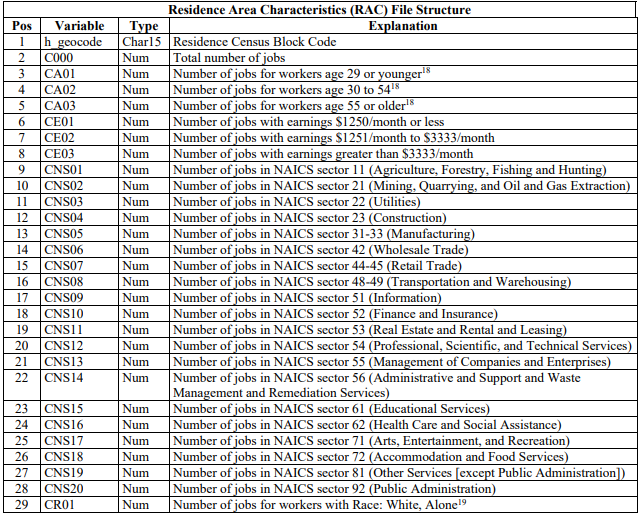
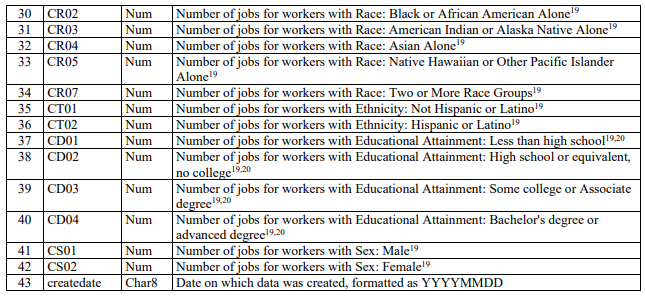

I will create four main occupational categories that capture different occupational categories; groups that in scholarly literature have been defined as sharing similar patterns of spatial organization based the occupational class structure of the New Economy (Cox, 2022). They include:

 - New Economy Low Wage: 
     - `CNS06` Wholesale trade 
     - `CNS07` Retail trade 
     - `CNS08` Trucking/warehouse 
     - `CNS14` Waste Admin/Security, includes janitors, landscapers, office clerks, security guards
     - `CNS18` Accomodation/Food Services

 - New Economy Mid Wage (but often college educated): 
     - `CNS15` Education 
     - `CNS16` Healthcare 
     - `CNS17` Arts, entertainment and rec 
     - `CNS19` Other Services, not Admin - ie: politics, non-profit work, NGOs etc 
     - `CNS20` Public Admin

 - New Economy High Wage (college educated, FIRE jobs): 
     - `CNS09` information 
     - `CNS10` finance and insurance 
     - `CNS11` Real Estate 
     - `CNS12` Professional, Scientific and Technical
     - `CNS13` Management of Companies and Enterprises

 - Old Economy Blue Collar: 
     - `CNS01` Agriculture 
     - `CNS02` Mining, Extraction 
     - `CNS03` Utilities
     - `CNS04` Construction 
     - `CNS05` Manufacturing 

The work plan is to download the data from the census link above, do some initial processing of the dataset to move from census block level data to census tract level data to make it joinable with our other economic, demographic, and social indicators above (a simple aggregation on the tract), create new columns based on the features, and normalize them based on total jobs (`C000`) in the tract.
     


In [27]:
# Load the MN LEHD RAC 2019 dataset
tc_lehd = pd.read_csv('mn_rac_S000_JT00_2019.csv.gz')

# Check
tc_lehd.head()

,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate
0,270017701001002,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,20211018
1,270017701001004,2,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,2,0,0,0,0,1,0,2,20211018
2,270017701001006,3,0,1,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,3,0,0,0,0,0,3,0,0,0,2,1,1,2,20211018
3,270017701001007,8,4,2,2,3,4,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,2,0,3,0,0,8,0,0,0,0,0,8,0,0,0,3,1,2,6,20211018
4,270017701001010,2,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,2,0,0,1,0,1,0,2,20211018


In [28]:
#find the dataype of geocode (int) - so many blocks!
tc_lehd['h_geocode'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 139274 entries, 0 to 139273
Series name: h_geocode
Non-Null Count   Dtype
--------------   -----
139274 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


In [29]:
#transform to string (no need to be a number)

tc_lehd['TR_10'] = tc_lehd['h_geocode'].astype(str)

#Extract just the tract (first 11 numbers of the fipcode contain info for census tract rather than block)

tc_lehd['TR_10'] = tc_lehd['TR_10'].str[0:11]

# confim
tc_lehd.head()

,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate,TR_10
0,270017701001002,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,20211018,27001770100
1,270017701001004,2,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,2,0,0,0,0,1,0,2,20211018,27001770100
2,270017701001006,3,0,1,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,3,0,0,0,0,0,3,0,0,0,2,1,1,2,20211018,27001770100
3,270017701001007,8,4,2,2,3,4,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,2,0,3,0,0,8,0,0,0,0,0,8,0,0,0,3,1,2,6,20211018,27001770100
4,270017701001010,2,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,2,0,0,1,0,1,0,2,20211018,27001770100


In [30]:
# Create new dataframe based on a groupby to aggregate columns to the tract level
tc_lehd1 = tc_lehd.groupby('TR_10').sum()

#reset the index
tc_lehd1.reset_index(inplace = True)

#drop h_geodcode and createdate
tc_lehd1.drop(columns = ['h_geocode', 'createdate'], inplace = True)

#test
tc_lehd1.head()

,TR_10,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02
0,27001770100,926,224,404,298,316,273,337,2,13,7,56,90,22,125,30,10,42,5,22,9,24,85,162,9,127,21,65,879,9,15,12,0,11,920,6,57,215,252,178,438,488
1,27001770200,921,191,420,310,290,305,326,7,11,7,67,100,15,137,21,8,21,10,18,5,28,81,154,5,114,37,75,885,9,12,4,1,10,913,8,64,219,310,137,414,507
2,27001770300,1467,326,737,404,435,505,527,4,8,21,101,74,38,179,29,6,53,13,34,14,56,110,331,30,182,73,111,1396,19,19,12,0,21,1440,27,97,359,443,242,649,818
3,27001770400,1139,248,564,327,313,413,413,8,15,12,47,161,27,117,51,8,28,6,27,14,31,126,178,20,146,32,85,1051,12,52,4,0,20,1122,17,77,300,332,182,566,573
4,27001790501,822,180,390,252,239,285,298,6,14,8,45,82,30,98,24,3,15,9,19,7,17,79,146,12,134,28,46,785,7,17,2,0,11,807,15,63,195,237,147,365,457


Right now we have the census tracts for the entire state of Minnesota. As we do some feature engineering to aggregate and normalize the data, we want to normalize the data on just the area of focus - the 7 county metro area. We therefore will create a list of census tracts in the 7 county region, and select only those that match that list.

In [31]:
# Create list of metro tracts
metro_tracts = metro_gdf['TR10']

# Extract metro tracts from the LEHD
tc_lehd2 = tc_lehd1[tc_lehd1['TR_10'].isin(metro_tracts)]

# Check info to see if entries match
tc_lehd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 6 to 1298
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TR_10   703 non-null    object
 1   C000    703 non-null    int64 
 2   CA01    703 non-null    int64 
 3   CA02    703 non-null    int64 
 4   CA03    703 non-null    int64 
 5   CE01    703 non-null    int64 
 6   CE02    703 non-null    int64 
 7   CE03    703 non-null    int64 
 8   CNS01   703 non-null    int64 
 9   CNS02   703 non-null    int64 
 10  CNS03   703 non-null    int64 
 11  CNS04   703 non-null    int64 
 12  CNS05   703 non-null    int64 
 13  CNS06   703 non-null    int64 
 14  CNS07   703 non-null    int64 
 15  CNS08   703 non-null    int64 
 16  CNS09   703 non-null    int64 
 17  CNS10   703 non-null    int64 
 18  CNS11   703 non-null    int64 
 19  CNS12   703 non-null    int64 
 20  CNS13   703 non-null    int64 
 21  CNS14   703 non-null    int64 
 22  CNS15   703 non-null    i

With the LEHD data aggregated by census tract, we will now create our new variables based on occupational category.

In [32]:
# Old Economy Blue Collar (OE_BC)
tc_lehd2['OE_BC'] = (tc_lehd2['CNS01'] + tc_lehd2['CNS02'] + tc_lehd2['CNS03'] + tc_lehd2['CNS04'] + tc_lehd2['CNS05'])/tc_lehd2['C000']

# New Economy Low Wage (NE_LW)
tc_lehd2['NE_LW'] = (tc_lehd2['CNS06'] + tc_lehd2['CNS07'] + tc_lehd2['CNS08'] + tc_lehd2['CNS14'] + tc_lehd2['CNS18'])/tc_lehd2['C000']

# New Economy Mid Wage (NE_MW)
tc_lehd2['NE_MW'] = (tc_lehd2['CNS15'] + tc_lehd2['CNS16'] + tc_lehd2['CNS17'] + tc_lehd2['CNS19'] + tc_lehd2['CNS20'])/tc_lehd2['C000']

# New Economy High Wage (NE_HW)
tc_lehd2['NE_HW'] = (tc_lehd2['CNS09'] + tc_lehd2['CNS10'] + tc_lehd2['CNS11'] + tc_lehd2['CNS12'] + tc_lehd2['CNS13'])/tc_lehd2['C000']

In [33]:
#create final to join with above and export
TC_LEHD = tc_lehd2[['TR_10', 'OE_BC', 'NE_LW', 'NE_MW', 'NE_HW']]

# export

In [34]:
#join with the Metro Table
tc_merged = metro_gdf.merge(TC_LEHD, left_on="TR10", right_on= "TR_10")


In [35]:
print(f'The shape of metro is {metro_gdf.shape}')
print(f'The shape of metro is {TC_LEHD.shape}')
print(f'the shape of the merged dataset is {tc_merged.shape}')

The shape of metro is (703, 127)
The shape of metro is (703, 5)
the shape of the merged dataset is (703, 132)


## Engineer Feature From Parcel Joined Dataset

To do this, we will spatially join the tc_gdf dataset with tract based information to the parcel point data set. This will attach tract attributes to all points *within* the boundaries of the tract. From here, we can aggregate on the tract to extract some new features.



In [36]:
parcels = gpd.read_file('twincities_parcels.gpkg')

In [37]:
#check that the projections are the same
parcels.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
metro_gdf.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [39]:
parcels_gdf = parcels.sjoin(tc_merged, how='left', predicate = 'within')

In [40]:
parcels_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 968441 entries, 0 to 968440
Columns: 144 entries, COUNTY_PIN to NE_HW
dtypes: float64(119), geometry(1), int64(5), object(19)
memory usage: 1.0+ GB


In [41]:
parcels_gdf.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,Homestead,Corporate,TAXOWN_NOTMN,geometry,index_right,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW
0,363425420001,Anoka,VESTA MINNESOTA PROPERTIES LLC,55443,Single_Family,2011,1987,343900.0,0,1,0,POINT (468988.693 5026377.395),0.0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229
1,363425410007,Anoka,"BRIERLEY, WENDY LOU",55070,Single_Family,2015,1996,382700.0,1,0,0,POINT (469548.186 5026281.306),0.0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229
2,363425410006,Anoka,FOSSE DAVID B & ELVIRA,55070,Single_Family,1996,1996,537900.0,1,0,0,POINT (469374.511 5026384.153),0.0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026

We will now engineer new features now available due to this spatial join:
- `TR_PARCELSALL` - All Parcels in the Tract
- `TR_SINGLEFAMTOT` - All Single Family Parcels in the Tract
- `TR_SNGLFAM_CORP` - All Single Family Parcels owned by a corporation in the Tract
- `TR_MULTIFAM_ALL` - All Multifamily in the tract
- `MFOWN_NOTMN` - All Multifamily owned by out of state taxpayer
- `MED_YRBUILT` - Median year built of parcels in the tract
- `RATIO_CORPSF` - `TR_SNGLFAM_CORP`/`TR_SINGLEFAMTOT` - ratio of all single family parcels owned by a corporation
- `RATIO_NOTMNMF` - `MFOWN_NOTMN`/`TR_MULTIFAM_ALL` - ratio of all multifamily parcels in the tract owned out of state

In [42]:
# Feature 1: How many parcels are in each tract?
TR_PARCELSALL = parcels_gdf.groupby('TR10')['COUNTY_PIN'].count()

# Add it to the tc_merged df
tc_merged = tc_merged.merge(TR_PARCELSALL, how='left', on = 'TR10')

#Display
tc_merged.head()

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW,COUNTY_PIN
0,27003050107,29450.685312,27003050107,St. Francis,1.00000,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.300,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.000,0.000,0.000,0.062,2007.0,0.101,0.960,0.000,0.000,0.000,0.000,0.040,0.040,"White, non-Latinx",0.960,0.000,0.002,0.000,0.000,0.000,0.000,0.017,0.000,0.0,0.030,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.060,23.0,0.040,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.000,0.013,682.0,0.307,0.171,33.0,3.326,1.60,0.93,1.39,4.0,82.568,0.064,6.81,8.80,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5...",0.699942,0.000000,0.076826,0.750102,6.059419,25.000000,24.462236,-42.657741,0.887350,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229,840.0
1,27003050108,27000.684440,27003050108,St. Francis,0.90697,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1978.0,1920.0,1613.0,307.0,5525.0,1808.0,1721.0,1446.0,275.0,5252.0,0.285,0.248,0.385,0.083,0.155,0.690,0.156,3.05,0.945,0.007,0.018,0.120,2011.0,0.110,0.871,0.021,0.005,0.060,0.001,0.042,0.129,"White, non-Latinx",0.871,0.011,0.015,0.001,0.001,0.053,0.000,0.005,0.001,0.0,0.000,0.342,0.154,0.161,0.0,0.0,0.295,0.0,0.0,68006.0,86612.0,0.158,0.339,0.139,0.614,0.126,52670.0,None,None,None,None,None,None,None,0.840,0.204,0.286,0.188,960.0,1041.0,169548.0,212700.0,0.7036,0.4024,0.101,57.0,0.027,0.013,0.0,2662.0,0.070,0.526,32.92,0.972,0.011,0.017,816.0,0.315,0.195,243.0,44.777,1.23,1.81,1.48,4.0,84.987,0.099,7.63,7.14,6.914,27000.684440,2.790857e+07,"POLYGON ((474792.463 5028953.926, 474818.440 5...",0.714851,0.105732,0.235573,0.767542,27.359351,8.437500,25.451200,-42.808414,0.815470,0.820704,27003050108,0.291538,0.273039,0.306954,0.128469,1924.0
2,27003050109,37346.985868,27003050109,East Bethel,1.00000,1.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,2000.0,1967.0,1866.0,101.0,5720.0,1921.0,1878.0,1741.0,137.0,5481.0,0.222,0.217,0.449,0.112,0.124,0.790,0.086,2.91,0.982,0.000,0.010,0.054,2005.0,0.096,0.930,0.004,0.014,0.020,0.014,0.018,0.070,"White, non-Latinx",0.930,0.000,0.010,0.000,0.000,0.020,0.000,0.004,0.003,0.0,0.000,0.332,0.194,0.118,0.0,0.0,0.401,0.0,0.0,97663.0,94318.0,0.081,0.253,0.186,0.625,0.100,51225.0,None,None,None,None,None,None,None,0.927,0.148,0.226,0.142,1032.0,1536.0,195898.0,252250.0,0.4757,0.1971,0.146,39.0,0.064,0.026,0.0,2926.0,0.040,0.547,34.44,0.978,0.010,0.012,454.0,0.219,0.291,111.0,1.547,6.46,7.25,1.82,3.0,84.109,0.119,9.21,6.45,6.941,37346.985868,6.923463e+07,"POLYGON ((488872.762 5027577.808, 488874.90

In [43]:
#rename
tc_merged.rename(columns= {"COUNTY_PIN": "TR_PARCELSALL"}, inplace=True)



In [44]:
#fillna with 0 (if the tract has no residential parcels, its okay to have it as 0)
tc_merged['TR_PARCELSALL'].fillna(value=0, inplace=True)

In [45]:
# Feature 2: How many single family parcels are there per tract?
# just single family homes
single_family = parcels_gdf.loc[parcels_gdf['Use_Class'] == 'Single_Family']

#groupby TR10
TR_SINGLEFAMTOT = single_family.groupby('TR10')['County'].count()

# Add it to the tc gdf
tc_merged = tc_merged.merge(TR_SINGLEFAMTOT, how='left', on = 'TR10')

tc_merged.head(1)

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW,TR_PARCELSALL,County
0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5...",0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229,840.0,833.0


In [46]:
#rename
tc_merged.rename(columns= {"County": "TR_SINGLEFAMTOT"}, inplace = True)

In [47]:
#fillna with 0 (if the tract has no parcels, its okay to have it as 0)
tc_merged['TR_SINGLEFAMTOT'].fillna(value=0, inplace=True)

In [48]:
#Feature 3 - Single Family Corporate Owned
single_fam_corp = single_family.loc[single_family['Corporate'] == 1]

#Group By
TR_SNGLFAM_CORP = single_fam_corp.groupby('TR10')['County'].count()

# Add it to the tc gdf
tc_merged = tc_merged.merge(TR_SNGLFAM_CORP, how='left', on = 'TR10')

tc_merged.head(1)

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW,TR_PARCELSALL,TR_SINGLEFAMTOT,County
0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5...",0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229,840.0,833.0,22.0


In [49]:
#rename
tc_merged.rename(columns= {"County": "TR_SNGLFAM_CORP"}, inplace= True)

In [50]:
tc_merged['TR_SNGLFAM_CORP'].fillna(value=0, inplace=True)

In [51]:
#Feature 4: All Multi_family
multi_fam = parcels_gdf.loc[(parcels_gdf['Use_Class'] == 'Multifamily_Large') | (parcels_gdf['Use_Class'] == 'Multifamily_Small')]

TR_MULTIFAM_ALL = multi_fam.groupby('TR10')['County'].count()

# Add it to the tc gdf
tc_merged = tc_merged.merge(TR_MULTIFAM_ALL, how='left', on = 'TR10')

tc_merged.head(1)

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW,TR_PARCELSALL,TR_SINGLEFAMTOT,TR_SNGLFAM_CORP,County
0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5...",0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229,840.0,833.0,22.0,7.0


In [52]:
#rename
tc_merged.rename(columns= {"County": "TR_MULTIFAM_ALL"}, inplace= True)

In [53]:
tc_merged['TR_MULTIFAM_ALL'].fillna(value=0, inplace=True)

In [54]:
#Feature 5: All Multi_family owned by an out of state corporation

# Pull out all multifamily parcels owned by an out of state corporation
multi_fam_notmn = multi_fam.loc[multi_fam['TAXOWN_NOTMN'] == 1]

# Group By Tract
TR_SNGLFAM_CORP = multi_fam_notmn.groupby('TR10')['TAXOWN_NOTMN'].sum()

# Add it to the tc gdf
tc_merged = tc_merged.merge(TR_SNGLFAM_CORP, how='left', on = 'TR10')

tc_merged.head(1)

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW,TR_PARCELSALL,TR_SINGLEFAMTOT,TR_SNGLFAM_CORP,TR_MULTIFAM_ALL,TAXOWN_NOTMN
0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5...",0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229,840.0,833.0,22.0,7.0,NaN


In [55]:
#rename
tc_merged.rename(columns= {"TAXOWN_NOTMN": "MFOWN_NOTMN"}, inplace= True)

In [56]:
tc_merged['MFOWN_NOTMN'].fillna(value=0, inplace=True)

In [57]:
#Feature 6: Median Year Built of Parcel
MED_YRBUILT = parcels_gdf.groupby('TR10')['YEAR_BUILT'].median()

#Add it to the tc gdf
tc_merged = tc_merged.merge(MED_YRBUILT, how='left', on= 'TR10')

tc_merged.head(1)

,GEOID10,Shape_Leng,TR10,CTU_PRMRY,PCTU_PRMRY,PCTU_WHOLE,WS_PRMRY,SD_PRMRY,TR_OPPZONE,TR_QUALIF,TR_EJ,TR_EDA,HUTOT_MC,HHTOT_MC,HHOWN_MC,HHRNT_MC,POPTOT_MC,HUTOT_ACS,HHTOT_ACS,HHOWN_ACS,HHRNT_ACS,POPTOT_ACS,P_0017,P_1834,P_3564,P_65UP,PHHSIZE1,PHHSIZE2_4,PHHSIZE5UP,AVGHHSIZE,P_USBORN,PMIG_GE10,P_ENGLIMIT,PMV,MV_MDYR,PD_ANY,PWHITENH,PBLACKNH,PASIANNH,PHISPPOP,PAMINDNH,POTHMULTNH,PBIPOC,PLURALRACE,PPLURALRAC,PBANC_AFRI,PBANC_AFAM,PARAC_AIND,PARAC_HMON,PLAT_MEXI,PLAT_PUER,PIND_DAKO,PIND_OJIB,PMENA_EGYP,PMENA_LEBA,PWANC_GERM,PWANC_NORW,PPOV185,ACP,ACP_NYRS,PPOV500,ACA,ACA_NYRS,MDHHINC14,MDHHINCNOW,PHHI_QNTL1,PHHI_QNTL3,PHHI_QNTL5,PWK_FTYR,PWK_NOWORK,MDERN_FTYR,HOLC_PGRN,HOLC_PBLU,HOLC_PYLW,HOLC_PRED,HOLC_PNR,RRCOV_NUM,RRCOV_PCT,POWNHOME,PCOSTBURD,PCOSTBURDR,PCOSTBURDO,GRSRENT14,GRSRENTNOW,MD_EMV_201,MD_EMV_NOW,AFF14_LE60,AFFNW_LE60,POZIP_SAME,N_EVICTED,P_EVICTED,PHH_NOVEH,PHFTRANSIT,COMM_TOTAL,PCOMM_LT5,PCOMM_GE20,COMMLENGTH,PCOMMDRIVE,PCOMMTRANS,PCOMMOTHER,JOB_TOTAL,PJOB_LT5,PJOB_GE20,RP_NETCHG,NRP_TOTAL,MI_TO_LIBR,MI_TO_PHAR,MI_TO_POST,N_DAYCARE,AVG_TEMP,PRIM_FLOOD,GHG_RES_PC,GHG_COM_PE,ENV_PM25,Shape_Le_1,Shape_Area,geometry,AGE_DIV,IMM_DIV,RACIAL_DIV,INCOME_DIV,INC_CHG,RENT_CHG,EMV_CHG,AFF_CHG,OWNER_RATIO,NBR_STAB,TR_10,OE_BC,NE_LW,NE_MW,NE_HW,TR_PARCELSALL,TR_SINGLEFAMTOT,TR_SNGLFAM_CORP,TR_MULTIFAM_ALL,MFOWN_NOTMN,YEAR_BUILT
0,27003050107,29450.685312,27003050107,St. Francis,1.0,0.0,Upper Rum River WMO,St. Francis,0.0,0.0,0.0,0.0,1083.0,1045.0,961.0,84.0,3034.0,1030.0,1006.0,928.0,78.0,2900.0,0.3,0.203,0.406,0.092,0.251,0.627,0.121,2.88,1.0,0.0,0.0,0.062,2007.0,0.101,0.96,0.0,0.0,0.0,0.0,0.04,0.04,"White, non-Latinx",0.96,0.0,0.002,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.03,0.398,0.132,0.231,0.0,0.0,0.205,0.0,0.0,76608.0,81250.0,0.208,0.374,0.078,0.587,0.138,54639.0,None,None,None,None,None,None,None,0.922,0.296,0.361,0.291,1120.0,1400.0,173868.0,216400.0,0.7021,0.4026,0.06,23.0,0.04,0.009,0.0,1613.0,0.087,0.517,37.12,0.987,0.0,0.013,682.0,0.307,0.171,33.0,3.326,1.6,0.93,1.39,4.0,82.568,0.064,6.81,8.8,6.907,29450.685312,3.587833e+07,"POLYGON ((466670.793 5025804.948, 466568.869 5...",0.699942,0.0,0.076826,0.750102,6.059419,25.0,24.462236,-42.657741,0.88735,1.148986,27003050107,0.268156,0.299441,0.311173,0.121229,840.0,833.0,22.0,7.0,0.0,1999.0


In [58]:
#rename
tc_merged.rename(columns= {"YEAR_BUILT": "MED_YRBUILT"}, inplace= True)

In [59]:
tc_merged['MED_YRBUILT'].fillna(value=0, inplace=True)

In [60]:
#Feature 7: `RATIO_CORPSF` - `TR_SNGLFAM_CORP`/`TR_SINGLEFAMTOT` - ratio of all single family parcels owned by a corporation
tc_merged['RATIO_CORPSF'] = tc_merged['TR_SNGLFAM_CORP']/tc_merged['TR_SINGLEFAMTOT']
tc_merged['RATIO_CORPSF'].fillna(value=0, inplace=True)

#Feature 8: `RATIO_NOTMNMF` - `MFOWN_NOTMN`/`TR_MULTIFAM_ALL` - ratio of all multifamily parcels in the tract owned out of state
tc_merged['RATIO_NOTMNMF'] = tc_merged['MFOWN_NOTMN']/tc_merged['TR_MULTIFAM_ALL']
tc_merged['RATIO_NOTMNMF'].fillna(value=0, inplace=True)


In [61]:
tc_merged.isna().sum()

GEOID10              0
Shape_Leng           0
TR10                 0
CTU_PRMRY            0
PCTU_PRMRY           0
PCTU_WHOLE           0
WS_PRMRY             0
SD_PRMRY             0
TR_OPPZONE           0
TR_QUALIF            0
TR_EJ                0
TR_EDA               0
HUTOT_MC             0
HHTOT_MC             0
HHOWN_MC             0
HHRNT_MC             0
POPTOT_MC            0
HUTOT_ACS            0
HHTOT_ACS            0
HHOWN_ACS            0
HHRNT_ACS            0
POPTOT_ACS           0
P_0017               0
P_1834               0
P_3564               0
P_65UP               0
PHHSIZE1             0
PHHSIZE2_4           0
PHHSIZE5UP           0
AVGHHSIZE            0
P_USBORN             0
PMIG_GE10            0
P_ENGLIMIT           0
PMV                  0
MV_MDYR              0
PD_ANY               0
PWHITENH             0
PBLACKNH             0
PASIANNH             0
PHISPPOP             0
PAMINDNH             0
POTHMULTNH           0
PBIPOC               0
PLURALRACE 

## Extract Combined Data Set

Identifiers
- `TR10`	Identifier for tract (2010 vintage)
- `CTU_PRMRY`Primary city/township (with a plurality of the tract's population)

Demographic Indicators
- `POPTOT_MC`	Total population (Metropolitan Council estimate)
- `AGE_DIV` Age diversity index
- `IMM_DIV` - Immigration Diversity index 
- `RACIAL_DIV` - A racial diversity index to capture the racial diversity of a neighborhood
- `PBLACKNH`	Proportion of residents who identify as Black or African American, non-Latino

Economic Indicators
- `PPOV185`	People whose family income is less than 185% of the federal poverty threshold, as a proportion of all people for whom poverty status is determined
- `ACP`	1 if Area of Concentrated Poverty (excludes tracts where PSTUDENT>=0.5 OR PPOV_STUDENT>=0.333 from the set of tracts where CONCPOV=1); 0 otherwise
- `PPOV500`	% of people whose income is at least 500% of the federal poverty threshold
- `ACA`	1 if Area of Concentrated Affluence (PPOV500_RAT >= 1.667 OR MD_EMV_RAT >= 1.667); 0 otherwise
- `TR_EDA`	Economically "Distressed" Area according to U.S. Economic Development Administration (1 = yes; 0 = no)
- `INCOME_DIV` - An income diversity index to capture the income diversity of a neighborhood
- `INC_CHG` - Measures percent change in household income
- `OE_BC` - Measures residential density of people who work in 'Old Economy Blue Collar' Occupations
- `NE_LW` - Measures residential density of people who work in 'New Economy Low Wage' Occupations
- `NE_MW` - Measures residential density of people who work in 'New Economy Medium Wage' Occupations
- `NE_HW` - Measures residential density of people who work in 'New Economy High Wage' Occupations


Commute Indicators
- `PHFTRANSIT`	Proportion of residents living within one-half mile of high-frequency transit
- `COMMLENGTH`	Mean commute length (in minutes)
- `PCOMMTRANS`	Proportion of commuters who took public transportation to work
- `PJOB_LT5`	Proportion of jobs held by workers who live less than 5 miles away (primary jobs only; excludes second or third jobs)

Environmental Indicators
- `TR_EJ`	Area of Environmental Justice Concern (1 = yes; 0 = no)
- `ENV_PM25`	Fine particulate matter (2.5 microns or less) (annual average micrograms per cubic meter); air quality standard is 12

Housing Indicators
- `PMV`	Proportion who moved to current housing unit in the last year (out of residents age 1+)
- `NBR_STAB`	Neighborhood Stability
- `POWNHOME`	Homeownership rate
- `PCOSTBURD`	% housing cost-burdened (housing costs are 30%+ of household income)
- `RP_NETCHG`	Net change in number of housing units, 2010-2019
- `TR_QUALIF`	Low-Income Housing Tax Credit Qualified Census Tract (1 = yes; 0 = no)
- `OWNER_RATIO` - Ratio of homeowners as proportion of total households
- `RENT_CHG` - Measures percent change rent
- `EMV_CHG` - Measures percent change in market value
- `AFF_CHG` - Measures percent change in deep affordability

Parcel Derived Variables
- `TR_PARCELSALL` - All Parcels in the Tract
- `TR_SINGLEFAMTOT` - All Single Family Parcels in the Tract
- `TR_SNGLFAM_CORP` - All Single Family Parcels owned by a corporation in the Tract
- `TR_MULTIFAM_ALL` - All Multifamily in the tract
- `MFOWN_NOTMN` - All Multifamily owned by out of state taxpayer
- `MED_YRBUILT` - Median year built of parcels in the tract
- `RATIO_CORPSF` - `TR_SNGLFAM_CORP`/`TR_SINGLEFAMTOT` - ratio of all single family parcels owned by a corporation
- `RATIO_NOTMNMF` - `MFOWN_NOTMN`/`TR_MULTIFAM_ALL` - ratio of all multifamily parcels in the tract owned out of state

- `geometry` Contains the geographical information for the polygon



In [62]:
metro_gdf_final = tc_merged[['TR10', 'CTU_PRMRY','POPTOT_MC', 'AGE_DIV', 'IMM_DIV', 'RACIAL_DIV', 'PBLACKNH', \
                  'PPOV185', 'ACP', 'PPOV500', 'ACA', 'TR_EDA', 'INCOME_DIV', 'INC_CHG', \
                   'OE_BC', 'NE_LW', 'NE_MW', 'NE_HW', \
                   'PHFTRANSIT', 'COMMLENGTH', 'PCOMMTRANS', 'PJOB_LT5',\
                  'TR_EJ', 'ENV_PM25', 'PMV', 'NBR_STAB', 'POWNHOME', \
                  'PCOSTBURD', 'RP_NETCHG', 'TR_QUALIF', 'OWNER_RATIO', \
                  'RENT_CHG', 'EMV_CHG', 'AFF_CHG', 'TR_PARCELSALL', \
                    'TR_SINGLEFAMTOT', 'TR_SNGLFAM_CORP', 'TR_MULTIFAM_ALL' ,\
                    'MFOWN_NOTMN', 'MED_YRBUILT', 'RATIO_CORPSF', 'RATIO_NOTMNMF', \
                    'geometry']]

#
print(f'The final dataframe has {metro_gdf_final.shape[0]} tracts and {metro_gdf_final.shape[1]} attributes.')

The final dataframe has 703 tracts and 43 attributes.


In [63]:
#Null free
metro_gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   TR10             703 non-null    object  
 1   CTU_PRMRY        703 non-null    object  
 2   POPTOT_MC        703 non-null    float64 
 3   AGE_DIV          703 non-null    float64 
 4   IMM_DIV          703 non-null    float64 
 5   RACIAL_DIV       703 non-null    float64 
 6   PBLACKNH         703 non-null    float64 
 7   PPOV185          703 non-null    float64 
 8   ACP              703 non-null    float64 
 9   PPOV500          703 non-null    float64 
 10  ACA              703 non-null    float64 
 11  TR_EDA           703 non-null    float64 
 12  INCOME_DIV       703 non-null    float64 
 13  INC_CHG          703 non-null    float64 
 14  OE_BC            703 non-null    float64 
 15  NE_LW            703 non-null    float64 
 16  NE_MW            703 non-null    flo

In [64]:
#export
metro_gdf_final.to_file('twincities_tracts.gpkg', driver='GPKG')

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
